## 1) Import Libraries <a class="anchor"  id="1"></a>

In [1]:
!pip install segmentation_models_pytorch 

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.5 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=ab2465d937519359c4d4d1b8ed231326b50ed75a3b384ac39d1e3b18f86efdc3
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=2c2a7a51350c57feaf825b60997c0cfcab80ba5596e51fde675a6fc1c7a072ff
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

In [2]:
!pip install transformers

In [3]:
from transformers import SegformerForSemanticSegmentation

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn

import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## 2) Custom VOC Dataset <a class="anchor"  id="2"></a>

### 2.1) Custom

In [5]:
VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

class VOCDataset(Dataset):
    def __init__(self, root="/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val",
                 is_train=True, transform=None, classes=None):
        # Choose the file for training or validation images
        if is_train:
            img_root = os.path.join(root, "ImageSets", "Segmentation", "train.txt")
        else:
            img_root = os.path.join(root, "ImageSets", "Segmentation", "val.txt")
        
        # Get image names into list
        img_names = []
        with open(img_root, 'r') as rf:
            names = [name.replace('\n','') for name in rf.readlines()]
            for name in names:
                img_names.append(name)
            
        self.classes =  classes
        self.transform = transform
        self.img_names = img_names
        self.root = root
        
    def __len__(self):
        return len(self.img_names)
    
    def _convert_to_segmentation_mask(self, mask):
        height, width = mask.shape[:2]
        # Initialize an empty mask with a channel for each class
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)))
        
        # Create a mask for each class label
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        
        return segmentation_mask

    
    def __getitem__(self, item):
        img_name = self.img_names[item]
        # Load the image and corresponding mask
        img = cv2.imread(os.path.join(self.root, "JPEGImages", img_name + ".jpg"))
        mask = cv2.imread(os.path.join(self.root, "SegmentationClass", img_name + ".png"))
        
        # Convert BGR to RGB format
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        # Convert RGB mask to segmentation mask
        mask = self._convert_to_segmentation_mask(mask)
        
        # Apply transformations if specified
        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            mask = mask.argmax(dim=2).squeeze()  # Convert multi-channel mask back to single-channel
        
        return img, mask

### 2.2) Test

In [6]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [7]:
trainsform = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
    ToTensorV2(),
])

VOC_dataset = VOCDataset(is_train= True, transform = trainsform)

32 312
Img: torch.Size([3, 224, 224])
Mask: torch.Size([224, 224])
Max Value Img: tensor(2.6400)
Max Value Mask: 20 | Unique Value Mask: tensor([ 0,  2,  9, 18, 20])


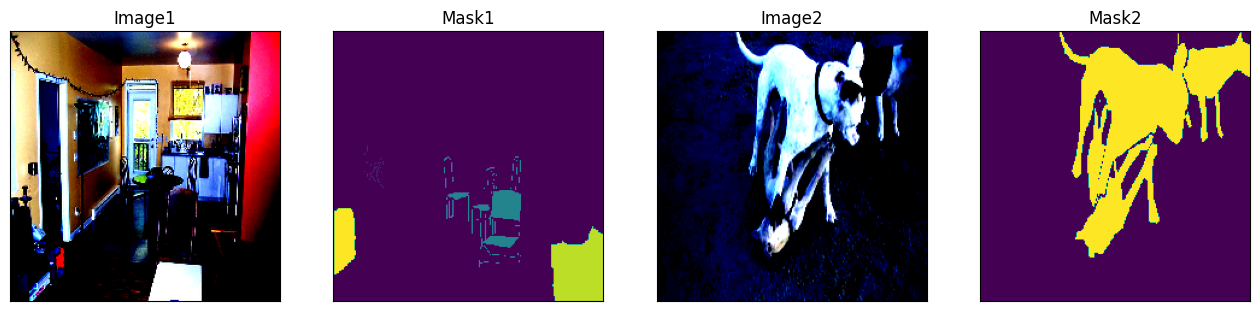

In [8]:
idx1, idx2 = np.random.randint(1,500), np.random.randint(1,500)
print(idx1,idx2)
img, mask = VOC_dataset[idx1]
img2, mask2 = VOC_dataset[idx2]
print("Img:", img.shape)
print("Mask:", mask.shape)
print("Max Value Img:",img.max())
print("Max Value Mask: {} | Unique Value Mask: {}".format(mask.max(), mask.unique()))

visualize(
    image1=img.permute(1,2,0), 
    mask1=mask.squeeze(),
    image2 = img2.permute(1,2,0),
    mask2 = mask2.squeeze(),
)

## 3) Traning Model  <a class="anchor"  id="3"></a>

### 3.1) Custom Metrics <a class="anchor"  id="3.1"></a>

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

### 3.2) Define Transform <a class="anchor"  id="3.2"></a>

In [12]:
# transform_size = 257
#Define trainform to images
def img_transform(trainsize= 256):
    train_transform = A.Compose([
    A.Rotate([-10,10]),
    A.RandomScale([0.5,2]),
    A.GaussianBlur(),
    A.HorizontalFlip(),
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
    ])

    test_transform = A.Compose([
        A.Resize(width=trainsize, height=trainsize),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
        ToTensorV2(), 
    ])
    return train_transform, test_transform

### 3.3) EarlyStopping <a class="anchor"  id="3.3"></a>

In [13]:
import copy

#patience, min_delta, restore_best_weights, best_model, best_loss counter status
#copy.deepcopy
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=False):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        """
        Call method to check if early stopping is triggered.

        Args:
        model (torch.nn.Module): The model being trained.
        val_loss (float): The validation loss of the current epoch.

        Returns:
        bool: True if early stopping should occur, False otherwise.
        """
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model.state_dict())

        elif self.best_loss - val_loss > self.min_delta:
            self.best_model = copy.deepcopy(model.state_dict())
            self.best_loss = val_loss
            self.counter = 0

        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stop on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model)
                return True  # Stop training
        self.status = f"{self.counter}/{self.patience}"
        return False # Continue training

### 3.4) Tracking The Training Phase <a class="anchor"  id="3.4"></a>

In [14]:
import matplotlib.pyplot as plt

def plot_segmentation_metrics(train_loss, val_loss, train_mean_iou=None, val_mean_iou=None, 
                              train_dice_score=None, val_dice_score=None):
    """
    Plot training and validation metrics (loss, mean IoU, Dice score) over epochs.

    Args:
    - train_loss (list): List of training loss values over epochs.
    - val_loss (list): List of validation loss values over epochs.
    - train_mean_iou (list, optional): List of training mean IoU values over epochs.
    - val_mean_iou (list, optional): List of validation mean IoU values over epochs.
    - train_dice_score (list, optional): List of training Dice score values over epochs.
    - val_dice_score (list, optional): List of validation Dice score values over epochs.
    """
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plotting the Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the Mean IoU (if available)
    if train_mean_iou and val_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_mean_iou, 'r', label='Training Mean IoU')
        plt.plot(epochs, val_mean_iou, 'b', label='Test Mean IoU')
        plt.title('Training and Test Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plotting the Dice Score (if available)
    if train_dice_score and val_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_dice_score, 'r', label='Training Dice Score')
        plt.plot(epochs, val_dice_score, 'b', label='Test Dice Score')
        plt.title('Training and Test Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

### 3.5) Traning fuction and Eval Fuction  <a class="anchor"  id="5"></a>

In [15]:
upsample = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)

In [16]:
# Training fuction
def train(model,train_dataloader,device,optimizer, epoch, EPOCHS, writer, train_loss_meter, criterion):
    model.train()
    train_progress= tqdm(train_dataloader, colour="cyan")
    
    for idx, img_mask in enumerate(train_progress):
        img = img_mask[0].float().to(device) #img - B,C,H,W
        mask = img_mask[1].long().to(device) #label - B,H,W
        y_pred = model(img).logits #B, 21, H, W
        y_pred =  upsample(y_pred)
        #Optimizer 
        optimizer.zero_grad()
        loss = criterion(y_pred, mask) 
        loss.backward()
        optimizer.step()
        
        train_loss_meter.update(loss.item())
        
        # tracking the loss function
        writer.add_scalar("Train/Loss", train_loss_meter.avg, epoch*len(train_dataloader)+idx)
        
        train_progress.set_description("TRAIN| Epoch: {}/{}| Iter: {}/{} | Train Loss: {:0.4f} | lr: {}".format(
            epoch+1, EPOCHS, idx, len(train_dataloader), loss, optimizer.param_groups[0]['lr']))
        
    return train_loss_meter.avg
        

In [17]:
#Evaluate function
def evaluate(model,val_dataloader,device, num_classes, intersection_meter, union_meter, target_meter, test_loss_meter, criterion):
    model.eval()
    
    with torch.no_grad():
        for idx, img_mask in enumerate(val_dataloader):
            img = img_mask[0].float().to(device)
            mask = img_mask[1].long().to(device) #B W H

            y_pred = model(img).logits #B, 21, H, W
            y_pred = upsample(y_pred)
            
            loss = criterion(y_pred, mask) 
            test_loss_meter.update(loss.item()) 
            
            # (B, 21, H, W) -> (B, 1, H, W) -> (B, H, W)
            y_pred = y_pred.argmax(dim=1).squeeze(dim=1)
            intersection, union, target = intersectionAndUnionGPU(y_pred.float(), mask.float(), num_classes)
            intersection, union, target = intersection.cpu().numpy(), union.cpu().numpy(), target.cpu().numpy()
            intersection_meter.update(intersection), union_meter.update(union), target_meter.update(target)
            
            if idx>35: break
            
        #compute acc, iou, dice
        accuracy_class = intersection_meter.sum / (target_meter.sum + 1e-10)
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D
        macc = np.mean(accuracy_class)
        miou = np.mean(iou_class) #mean vector 21D
        mdice = np.mean(dice_class) #mean vector 21D
        
    return macc, miou, mdice, test_loss_meter.avg

### 3.6) Traning Segformer Model <a class="anchor"  id="3.6"></a>

In [19]:
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch.nn.functional as F

import segmentation_models_pytorch as smp
import shutil
from tqdm import tqdm
from transformers import SegformerForSemanticSegmentation, SegformerConfig


In [20]:
def main(learning_rate, batch_size, epochs, num_workers, data_path, model_save_path, tensorboard_path, num_classes, checkpoint_path):
    
    # Create model save directory if it doesn't exist
    if not os.path.isdir(model_save_path):
        os.mkdir(model_save_path)
    # Creater tensorboard directory
    if os.path.isdir(tensorboard_path):
        shutil.rmtree(tensorboard_path)
    os.mkdir(tensorboard_path)
    
    
    # Data augmentation and preprocessing for training and testing
    train_transform, test_transform = img_transform()
    
    # Create datasets and dataloaders
    train_dataset = VOCDataset(is_train=True, transform=train_transform)
    test_dataset = VOCDataset(is_train=False, transform=test_transform)

    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    
    # Load model and move it to the appropriate device
    segformer_version = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(segformer_version)
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = torch.nn.Conv2d(in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))
    model.to(device)
    
    # Initialize optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = smp.losses.DiceLoss(mode="multiclass", classes = num_classes, log_loss = False, from_logits = True, smooth=1e-8)
    
    # Best validation IoU for saving the best model
    best_predict = -1
    current_epoch = 0
                                   
    # Metrics
    train_loss_list = []
    test_loss_list = []
    train_loss_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    target_meter = AverageMeter()
    
    # Early Stop
    es = EarlyStopping(patience=14,restore_best_weights=False)
    
    # set up learning rate scheduler
    scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold= 1e-4, min_lr=0)
     
    # difine Tensorboard    
    writer = SummaryWriter(tensorboard_path)
    
    
    # Training loop
    for epoch in range(current_epoch,epochs): #EPOCHS
        intersection_meter.reset()
        union_meter.reset()
        target_meter.reset()
        
        #Start training model
        train_loss = train(model,train_dataloader,device,optimizer, epoch, epochs, writer, train_loss_meter,criterion)
        acc, miou, dice, test_loss = evaluate(model,val_dataloader,device, num_classes, intersection_meter, union_meter, target_meter, test_loss_meter, criterion)
        
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        
        # write in tensorboard
        writer.add_scalar("Test/Acc", acc, epoch)
        writer.add_scalar("Test/mIOU", miou, epoch)
        writer.add_scalar("Test/Dice", dice, epoch)
        
        # update learning rate
        scheduler.step(1-miou)

        #Create checkpoint
        checkpoint = {
            "model_state_dict": model.state_dict(),
            "epoch": epoch, 
            "optimizer_state_dict": optimizer.state_dict(),
            "miou": miou
        }
        
        # Save last checkpoint
        torch.save(checkpoint, os.path.join(model_save_path, "last.h5"))
        
        # Save best checkpoint based on dice score
        if miou > best_predict:
            torch.save(checkpoint, os.path.join(model_save_path, "best.h5"))
            best_predict = miou
            
        if es(model, 1-miou):
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break
            
        print("VAL| Acc:{:0.4f}  | mIOU: {:0.4f} | Dice: {:0.4f} | Test Loss: {:0.4f}| EStop: {}".format(
             acc, miou, dice, test_loss, es.status))
        
    #show tracking plot
    plot_segmentation_metrics(train_loss_list, test_loss_list)
        

TRAIN| Epoch: 1/5| Iter: 51/52 | Train Loss: 0.6643 | lr: 0.0001: 100%|██████████| 52/52 [04:04<00:00,  4.70s/it]


VAL| Acc:0.5855  | mIOU: 0.2858 | Dice: 0.3992 | Test Loss: 0.6914| EStop: 0/14


TRAIN| Epoch: 2/5| Iter: 51/52 | Train Loss: 0.7191 | lr: 0.0001: 100%|██████████| 52/52 [04:15<00:00,  4.91s/it]


VAL| Acc:0.7282  | mIOU: 0.3264 | Dice: 0.4594 | Test Loss: 0.6352| EStop: 0/14


TRAIN| Epoch: 3/5| Iter: 51/52 | Train Loss: 0.5511 | lr: 0.0001: 100%|██████████| 52/52 [04:12<00:00,  4.85s/it]


VAL| Acc:0.7919  | mIOU: 0.4441 | Dice: 0.5857 | Test Loss: 0.5803| EStop: 0/14


TRAIN| Epoch: 4/5| Iter: 51/52 | Train Loss: 0.3528 | lr: 0.0001: 100%|██████████| 52/52 [04:09<00:00,  4.80s/it]


VAL| Acc:0.8367  | mIOU: 0.5499 | Dice: 0.6821 | Test Loss: 0.5317| EStop: 0/14


TRAIN| Epoch: 5/5| Iter: 51/52 | Train Loss: 0.4012 | lr: 0.0001: 100%|██████████| 52/52 [04:09<00:00,  4.80s/it]


VAL| Acc:0.7820  | mIOU: 0.5590 | Dice: 0.6923 | Test Loss: 0.4971| EStop: 0/14


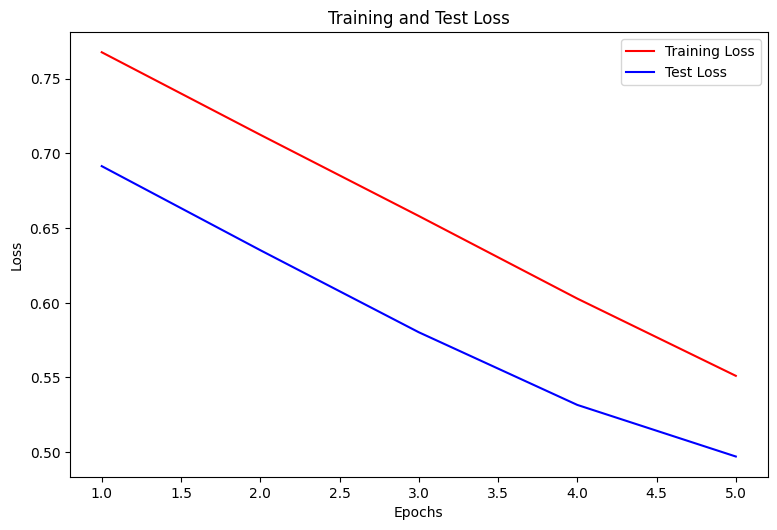

In [22]:
if __name__ == '__main__':
    # Hyperparameters and paths
    learning_rate = 1e-4
    batch_size = 28
    epochs = 5
    num_workers = os.cpu_count()
    data_path = "data"
    model_save_path = "/kaggle/working/trained_model"
    tensorboard_path = "/kaggle/working/tensorboard"
    num_classes = 21
    # Start training
    main(learning_rate,batch_size,epochs,num_workers,data_path,model_save_path,
        tensorboard_path,num_classes,model_save_path)
    pass

## 4) Inference <a class="anchor"  id="4"></a>

In [23]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

In [24]:
def pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = None):
    # Load model checkpoint
    checkpoint = torch.load(model_pth)
    model = model

    # Load the updated state_dict into the model
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()

    # Load validation dataset
    image_dataset = VOCDataset(is_train=False, transform=test_transform)

    images, orig_masks, pred_masks = [], [], []
    ids = []
    # Assigned Indexs to Show
    if assigned_ids:
        ids = assigned_ids
    else:
        ids = [np.random.randint(len(image_dataset)) for _ in range(num_imgs)]
    print("indexs:", ids)
    with torch.no_grad():
        for i in range(num_imgs) :
            ori_img, mask = image_dataset[ids[i]]
            img = ori_img
            img = img.to(device).float().unsqueeze(0)
            y_pred = model(img).logits
            y_pred = upsample(y_pred).squeeze(0) #1, 21, H, W --> 21, H, W
            
            #21, H, W --> H, W
            y_pred = y_pred.argmax(dim=0).cpu().numpy()
            mask = mask.cpu().numpy()
            
            # Colorize masks
            color_pred_mask = np.zeros((*y_pred.shape, 3))
            color_mask = np.zeros((*mask.shape, 3))
            
            for idx, color in enumerate(VOC_COLORMAP):
                color_pred_mask[y_pred==idx] =color
                color_mask[mask==idx] = color
            
            orig_masks.append(color_mask)
            pred_masks.append(color_pred_mask)
            images.append(unorm(ori_img).permute(1, 2, 0))

    # Combine images and masks for display
    images.extend(orig_masks)
    images.extend(pred_masks)

    # Plot images and masks
    fig = plt.figure(figsize=(20, 10))
    for i in range(1, 3*num_imgs + 1):
        fig.add_subplot(3, num_imgs, i)
        plt.imshow(images[i - 1])
    plt.show()

In [25]:
# Define the transformation to be applied to the test images
_, test_transform = img_transform()

#Define model
segformer_version = "nvidia/segformer-b3-finetuned-ade-512-512"
model = SegformerForSemanticSegmentation.from_pretrained(segformer_version)
in_channels = model.decode_head.classifier.in_channels
model.decode_head.classifier = torch.nn.Conv2d(in_channels, num_classes, kernel_size=(1, 1), stride=(1, 1))

#Note: You must train the model before using this param
model_pth = "/kaggle/working/trained_model/best.h5"
device = "cuda" if torch.cuda.is_available() else "cpu" 
num_classes=  21
num_imgs = 10


/tmp/ipykernel_30/3163179541.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pth)


indexs: [484, 1218, 172, 369, 1006, 1150, 1051, 844, 972, 757]


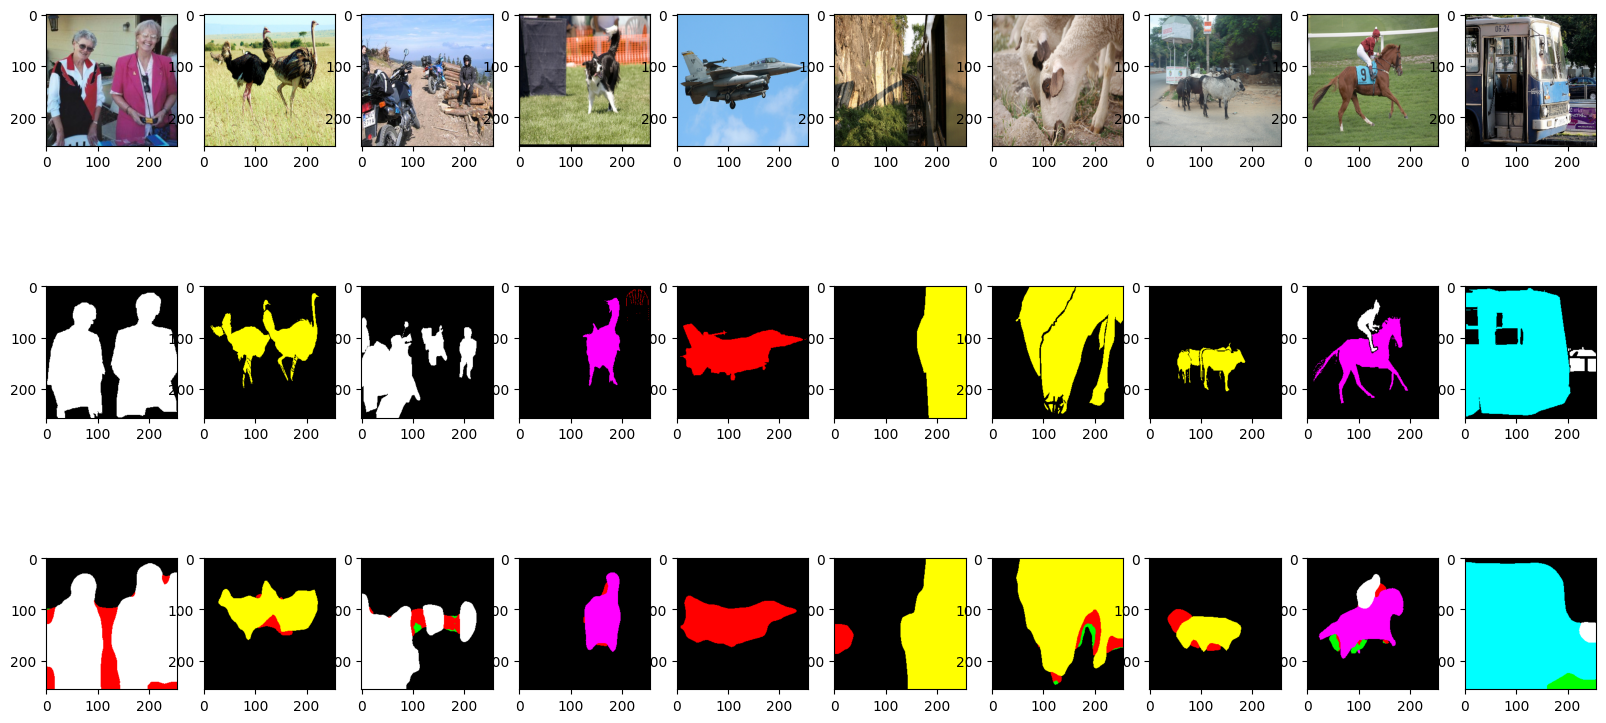

In [26]:
pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = None)

/tmp/ipykernel_30/3163179541.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pth)


indexs: [1231, 772, 48, 368, 1144, 1443, 700, 610, 511, 753]


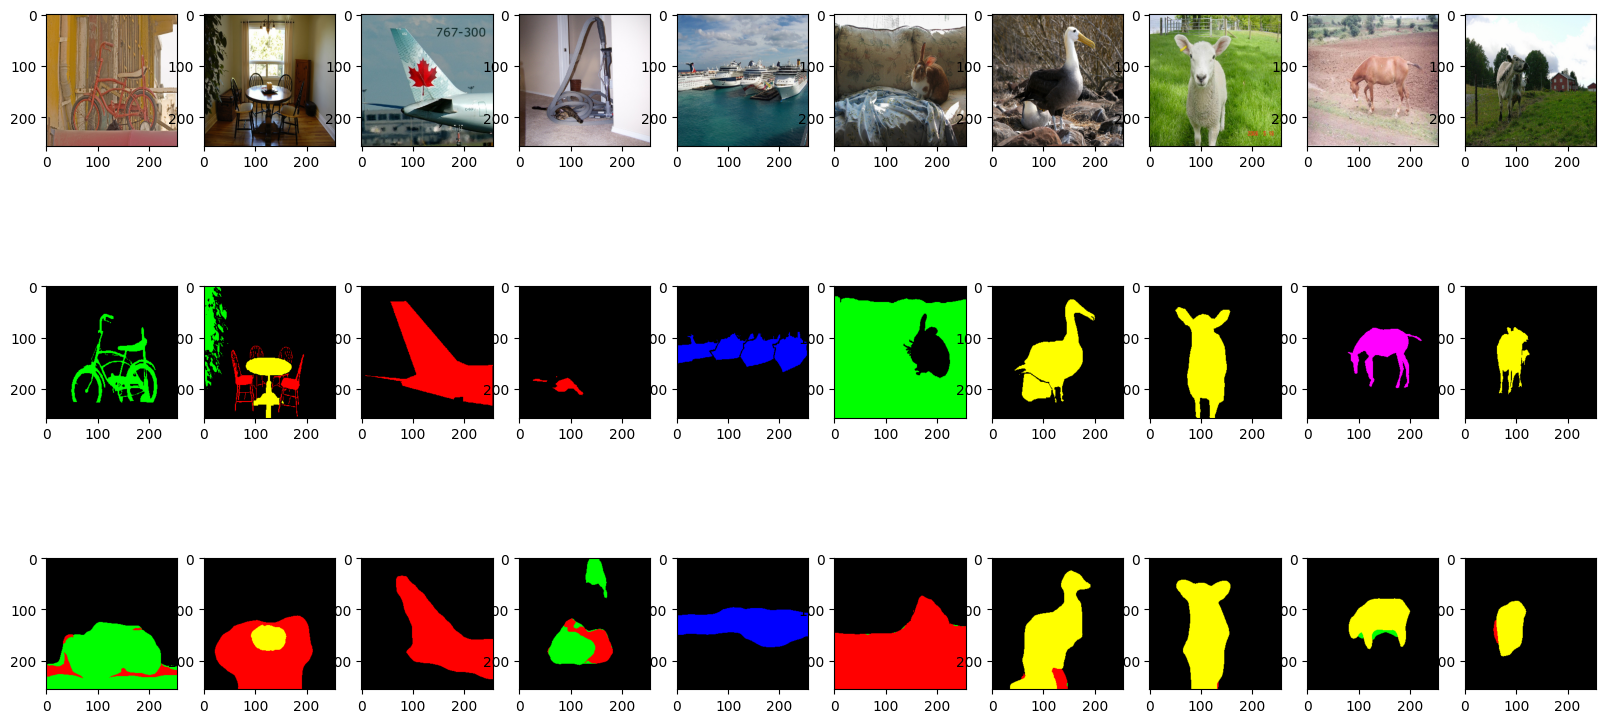

In [27]:
pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = [1231, 772, 48, 368, 1144, 1443, 700, 610, 511, 753])

/tmp/ipykernel_30/3163179541.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pth)


indexs: [58, 89, 25, 32, 4, 64, 88, 85, 28, 38]


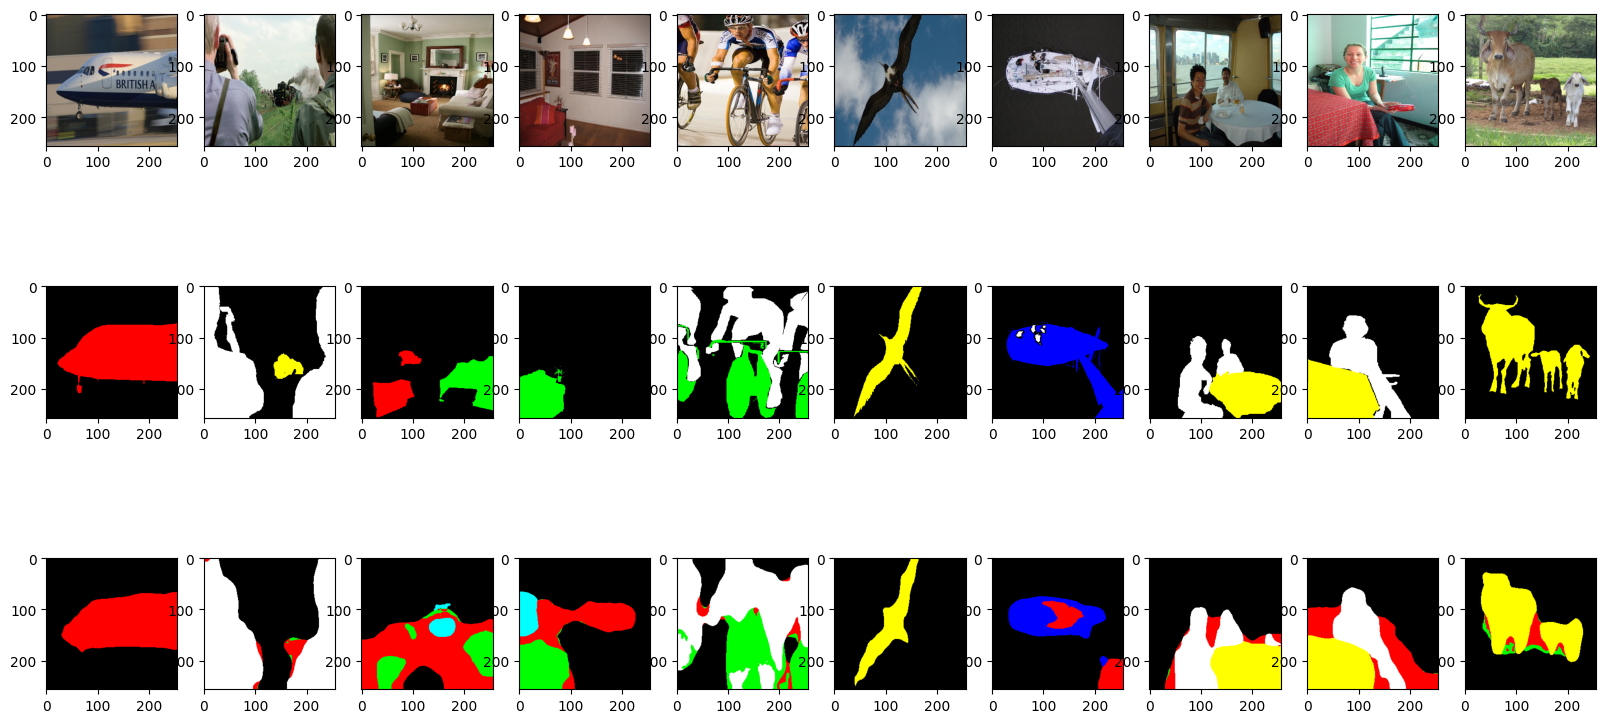

In [28]:
pred_show_image_grid(model_pth,model, device, test_transform, num_classes, num_imgs, assigned_ids = [58, 89, 25, 32, 4, 64, 88, 85, 28, 38])

In [29]:
!pip install torch torchvision pillow

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np

# Define constants
NUM_CLASSES = 11  # 10 classes + background
DATA_PATH = '/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/'
ANNOTATIONS_PATH = os.path.join(DATA_PATH, 'Annotations')
JPEGIMAGES_PATH = os.path.join(DATA_PATH, 'JPEGImages')

# Custom dataset for Pascal VOC
class PascalVOCDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = list(sorted(os.listdir(os.path.join(root, 'JPEGImages'))))
        self.annotations = list(sorted(os.listdir(os.path.join(root, 'Annotations'))))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, 'JPEGImages', self.images[idx])
        img = Image.open(img_path).convert("RGB")
        target = self.parse_voc_annotation(os.path.join(self.root, 'Annotations', self.annotations[idx]))

        if self.transform:
            img = self.transform(img)

        return img, target

    def parse_voc_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall('object'):
            label = obj.find('name').text
            if label not in class_mapping:
                continue
            labels.append(class_mapping[label])

            bndbox = obj.find('bndbox')
            boxes.append([
                float(bndbox.find('xmin').text),
                float(bndbox.find('ymin').text),
                float(bndbox.find('xmax').text),
                float(bndbox.find('ymax').text)
            ])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Ensure at least an empty tensor is returned
        if boxes.numel() == 0:
            boxes = torch.empty((0, 4), dtype=torch.float32)  # Shape [0, 4]

        target = {'boxes': boxes, 'labels': labels}
        return target


# Class mapping for Pascal VOC (10 classes + background)
class_mapping = {
    'aeroplane': 1,
    'bicycle': 2,
    'bird': 3,
    'boat': 4,
    'bottle': 5,
    'car': 6,
    'cat': 7,
    'dog': 8,
    'horse': 9,
    'sheep': 10
}

# Define transformation
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

# Create dataset and dataloader
dataset = PascalVOCDataset(DATA_PATH, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Load pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the model to fit our number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, NUM_CLASSES)

# Move model to the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Train the model
model.train()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 5  # Adjust as necessary
for epoch in range(num_epochs):
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f'Epoch: {epoch + 1}, Loss: {losses.item()}')

# Inference and visualization
model.eval()
with torch.no_grad():
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        output = model(images)

        # Visualize the output
        for i in range(len(images)):
            plt.figure(figsize=(12, 12))
            plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
            boxes = output[i]['boxes'].cpu().numpy()
            labels = output[i]['labels'].cpu().numpy()

            for box, label in zip(boxes, labels):
                if label > 0:  # Only plot for detected classes
                    x1, y1, x2, y2 = box
                    plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2))
                    plt.gca().text(x1, y1, class_mapping[label], fontsize=12, color='white', backgroundcolor='red')

            plt.axis('off')
            plt.show()
        break  # Remove this if you want to visualize more than one image
